In [6]:
#load network pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import sys

# Constants
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
model_path = 'face_detector.pth'

class FaceDetector(nn.Module) :
    def __init__(self, num_channels=3, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH) :
        super(FaceDetector, self).__init__()
        self.h_dim = image_height
        self.w_dim = image_width
    
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        # padding = 1 -> no change in size
        # maxpooling 2x2 -> both dimensions divided by 4
        self.h_dim //= 2  # 32
        self.w_dim //= 2  # 32

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2,2)
        # padding = 1 -> no change in size
        # maxpooling 2x2 -> both dimensions divided by 4
        self.h_dim //= 2  # 16
        self.w_dim //= 2  # 16 

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2, 2)
        # padding = 1 -> no change in size
        # maxpooling 3x4 -> height divided by 3, width divided by 4
        self.h_dim //= 2  # 8
        self.w_dim //= 2  # 8

        self.linear = nn.Linear(self.h_dim * self.w_dim * 64, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x) :
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = x.view(-1, self.h_dim * self.w_dim * 64)
        x = self.linear(x)
        x = self.softmax(x)
        return x
    

def load_model(model_path) :
    model = FaceDetector()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()
    return model

model = load_model(model_path)

/tmp/ipykernel_28286/3262451604.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'))


In [ ]:
#load dataset

import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms.functional as trF
import matplotlib.pyplot as plt
import random as rd

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
NORMALIZED_MEAN = [0.485, 0.456, 0.406]
NORMALIZED_STD = [0.229, 0.224, 0.225]

# Set paths and other constants
dataset_path = '/itet-stor/hfontaine/net_scratch/datasets'
split_selection = 'val'
preprocessed_path = os.path.join(dataset_path, 'PreprocessedWider', split_selection)

# Custom dataset class to read preprocessed images
class PreprocessedWiderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpeg')]
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and label
        image_name = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path)  # Open image
        image = trF.to_tensor(image)  # Convert image to tensor
        image = trF.normalize(image, NORMALIZED_MEAN, NORMALIZED_STD)  # Normalize image
        # Extract the label from the filename (before the '.jpeg' extension)
        label = int(image_name.split('_')[-1][0])  # 'image_00_1.jpeg' -> label = 1
        if label :
            return image, torch.tensor([1, 0], dtype=torch.float32) 
        else:
            return image, torch.tensor([0, 1], dtype=torch.float32)

# Instantiate the dataset and dataloader
dataset = PreprocessedWiderDataset(root_dir=preprocessed_path)

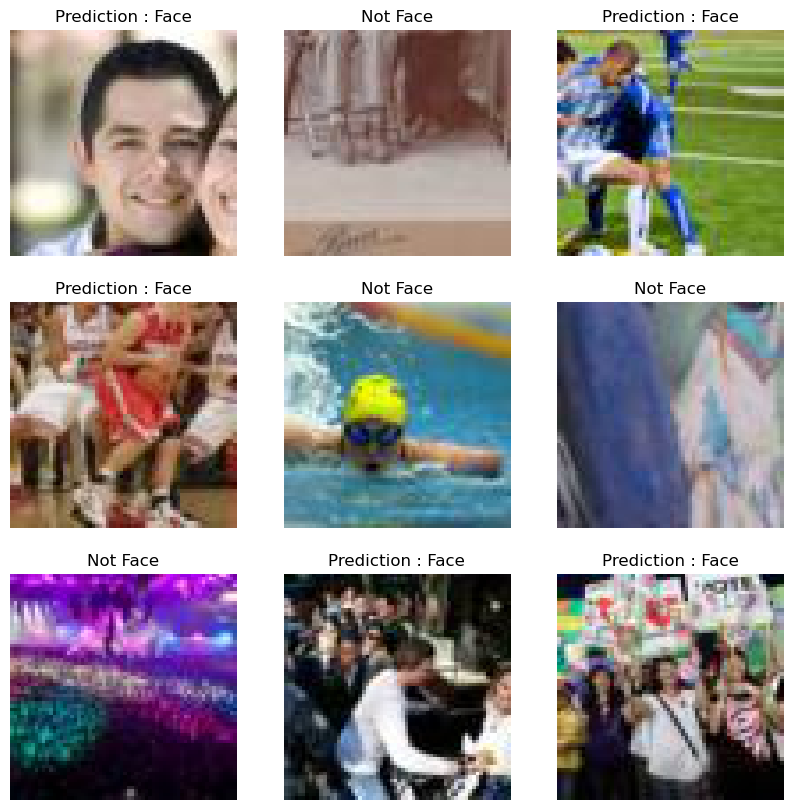

In [11]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
NORMALIZED_MEAN = [0.485, 0.456, 0.406]
NORMALIZED_STD = [0.229, 0.224, 0.225]

def unnormalize_image(image, mean, std):
    """
    Reverse the normalization process for a single image.
    Args:
        image (Tensor): Normalized image tensor of shape (C, H, W)
        mean (Tensor): Mean values used during normalization
        std (Tensor): Std values used during normalization
    Returns:
        Tensor: Unnormalized image tensor of shape (C, H, W)
    """
    mean = mean[:, None, None]  # Adjust shape to match (C, H, W)
    std = std[:, None, None]
    return image * std + mean


# prediction form : [1, 0] -> face, [0, 1] -> not face

nb_images_to_display = 9
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(nb_images_to_display):
    idx = rd.randint(0, len(dataset))
    image, label = dataset[idx]
    prediction = model(image)
    image = unnormalize_image(image, torch.tensor(NORMALIZED_MEAN), torch.tensor(NORMALIZED_STD))
    prediction = prediction.detach().numpy()
    prediction = np.argmax(prediction)
    image = image.permute(1, 2, 0).numpy()
    axs[i // 3, i % 3].imshow(image)
    axs[i // 3, i % 3].set_title("Prediction : " + "Face" if prediction == 0 else "Not Face")
    axs[i // 3, i % 3].axis('off')
plt.show()